# Initialization

In [38]:
import os

if os.getcwd().endswith("notebooks"):
    os.chdir("..")
    print("using project root as working dir")

In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

In [3]:
import torch

device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
print(f"using {device} device")

using cuda device


# Run

In [6]:
from src.graph import random_geometric_graph, random_graph, girg_graph
from dataclasses import asdict
from src.args import gridsearch_args, Args
from datetime import datetime
import time
import seaborn as sns
import pandas as pd
import glob

from src.evaluator import Evaluator

In [5]:
experiment = dict(
    key=datetime.now().strftime("%d-%m--%H-%M"),
    reps=3,
    skip_to=27,
    args=gridsearch_args(),
    # args=[ Args(graph_type="girg") ],
)
df_result = pd.DataFrame({})

run_len = len(experiment['args']) * experiment['reps']
for i, args in enumerate(experiment["args"]):
    # override args for specific test
    args.graph_type = "girg"

    # skip to beginning of specified repetition block
    if i < int(experiment['skip_to'] / experiment['reps']):
        print(f"skipping {i * experiment['reps']} to {(i + 1) * experiment['reps'] - 1}")
        continue

    # run with repetitions
    for rep in range(experiment["reps"]):
        run_index = i * experiment['reps'] + rep
        print(f"running evaluator {run_index}/{run_len}")

        if args.graph_type == "rgg":
            graph, dim = random_geometric_graph(
                size=args.graph_size,
                radius=args.rg_radius
            )
        elif args.graph_type == "random":
            graph, dim = random_graph(
                size=args.graph_size
            )
        elif args.graph_type == "girg":
            graph, dim = girg_graph(
                size=args.graph_size
            )
        else:
            raise ValueError(f"invalid graph type: {args.graph_type}")

        evaluator = Evaluator(
            graph=graph,
            dim=dim,
            args=args,
            writer_log_dir=f"runs/{experiment['key']}/s{args.epoch_graph_size}-a{args.epoch_graph_alpha}-b{args.epoch_graph_boredom_pth}-l{args.layers}xs{args.layer_size}--{rep}",
            device=device
        )
        start_time = time.time()
        evaluator.train(
            optimizer=torch.optim.Adam(evaluator.net.parameters(), lr=1e-3),
            save_fig=False
        )
        end_time = time.time()
        test_loss, test_ap, test_f1 = evaluator.test(
            epoch=args.epochs,
            save_fig=True
        )

        df_result = pd.concat([
            df_result,
            pd.Series({
                # run meta
                "run_index": run_index,
                "run_time": end_time - start_time,
                # run results
                "loss": test_loss,
                "ap": test_ap,
                "f1": test_f1,
                # run args
                **asdict(args),
            }).to_frame().T
        ], ignore_index=True)

    # save results just in case the run fails mid run
    df_result.to_csv(f"{experiment['key']}.csv.zip", index=False, compression=dict(method='zip', archive_name=f"{experiment['key']}.csv"))

skipping 0 to 2
skipping 3 to 5
skipping 6 to 8
skipping 9 to 11
skipping 12 to 14
skipping 15 to 17
skipping 18 to 20
skipping 21 to 23
skipping 24 to 26
running evaluator 27/30


building evaluator:   0%|          | 0/10 [00:00<?, ?it/s]

training model...: 0it [00:00, ?it/s]

testing model:   0%|          | 0/5 [00:00<?, ?it/s]

running evaluator 28/30


building evaluator:   0%|          | 0/10 [00:00<?, ?it/s]

training model...: 0it [00:00, ?it/s]

testing model:   0%|          | 0/5 [00:00<?, ?it/s]

running evaluator 29/30


building evaluator:   0%|          | 0/10 [00:00<?, ?it/s]

training model...: 0it [00:00, ?it/s]

testing model:   0%|          | 0/5 [00:00<?, ?it/s]

# Results

    epoch_graph_size  epoch_graph_alpha        ap
4                 50               1.00  0.059147
1                 50               0.25  0.236573
3                 50               0.75  0.240182
0                 50               0.00  0.275210
9                100               1.00  0.283928
2                 50               0.50  0.336239
5                100               0.00  0.422036
7                100               0.50  0.478724
6                100               0.25  0.500785
8                100               0.75  0.534281
11               250               0.25  0.539629
13               250               0.75  0.552610
12               250               0.50  0.588794
10               250               0.00  0.654436
14               250               1.00  0.668142


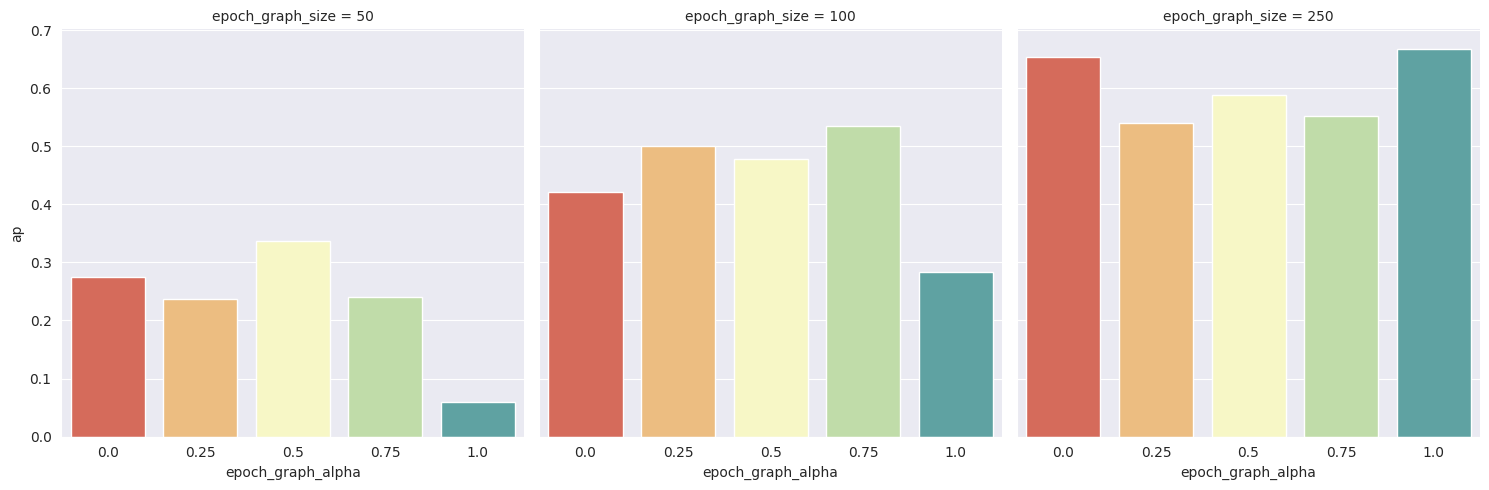

In [31]:
# mean score (bars)
df_result_mean_ap = df_result.groupby(["epoch_graph_size", "epoch_graph_alpha"], as_index=False)["ap"].mean().sort_values(by=['ap'])
print(df_result_mean_ap)

sns.catplot(
    data=df_result_mean_ap,
    col="epoch_graph_size",
    x="epoch_graph_alpha",
    y="ap",
    palette="Spectral",
    kind = "bar"
)

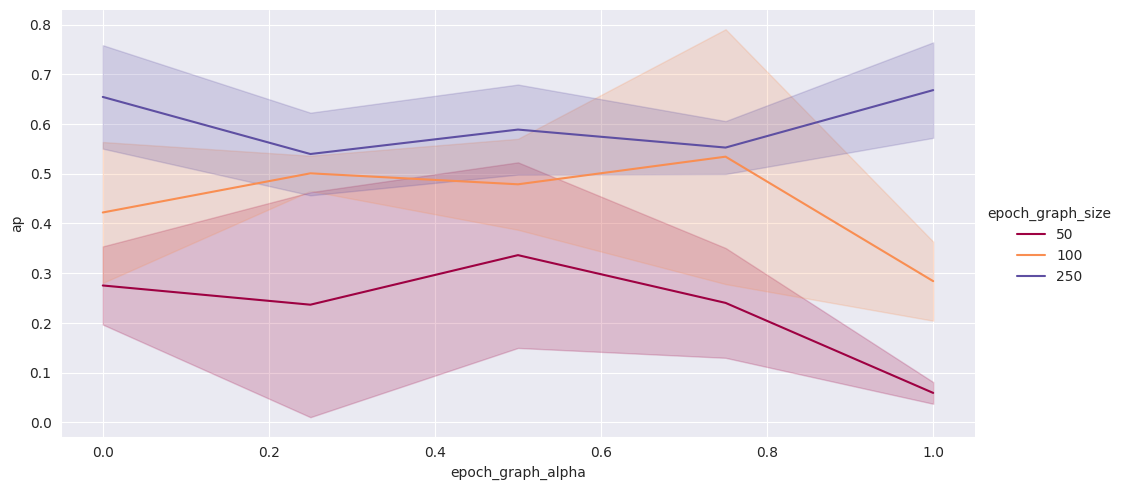

In [14]:
# score per epoch graph size and alpha (line with std)
sns.relplot(
    data=df_result, kind="line",
    hue="epoch_graph_size",
    x="epoch_graph_alpha",
    y="ap",
    errorbar="sd",
    palette="Spectral",
    aspect=2,
)

In [ ]:
# run time per graph and epoch graph size (line with std)
sns.relplot(
    data=df_result, kind="line",
    hue="epoch_graph_size",
    x="graph_size",
    y="run_time",
    errorbar="sd",
    palette="Spectral",
    aspect=2,
)

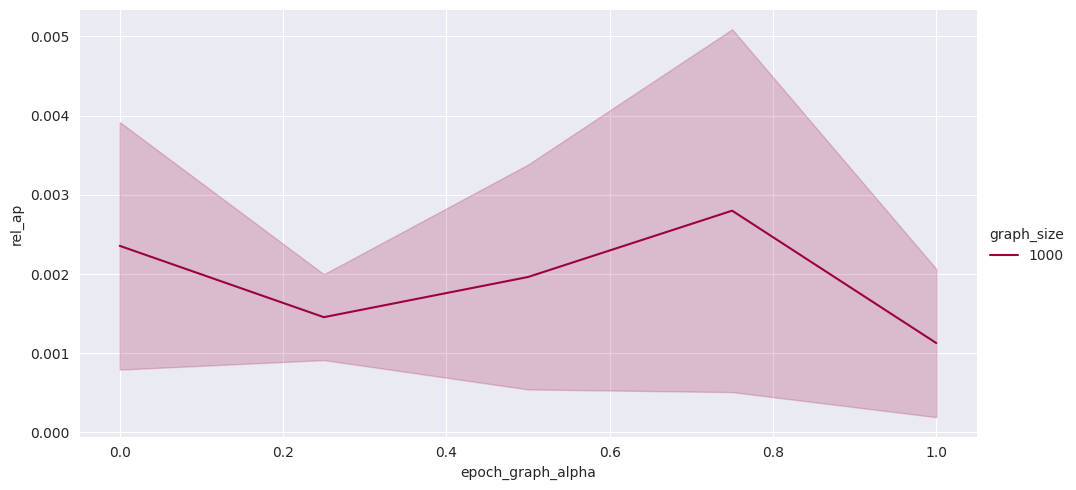

In [16]:
# score per time
df_result["rel_ap"] = df_result['ap'] / df_result['run_time']
sns.relplot(
    data=df_result, kind="line",
    hue="graph_size",
    x="epoch_graph_alpha",
    y="rel_ap",
    errorbar="sd",
    palette="Spectral",
    aspect=2,
)

# Next Tasks

- bigger graphs
    - how much more time?
- different graph types
    - girgs (https://github.com/chistopher/girgs) is like power law
- rgg: reconstruct threshold radius based on test nodes and f1-score

# Writing
- best 10-20 pages
- until 18.

# Load folder

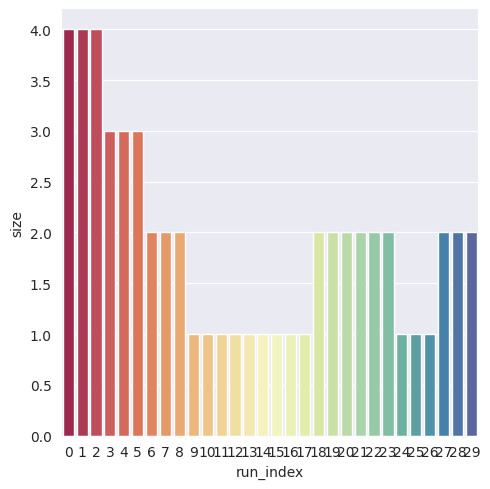

In [34]:
path = "./results/girg"
all_files = glob.glob(os.path.join(path, "*.csv.zip"))
df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
df_result = df
#df_result.to_csv(os.path.join(path, "complete.csv.zip"), index=False, compression=dict(method='zip', archive_name=f"complete.csv"))

df_result_count = df_result.groupby(["run_index"], as_index=False)["run_index"].size()
sns.catplot(
    data=df_result_count,
    x="run_index",
    y="size",
    palette="Spectral",
    kind="bar"
)

# Print Test

In [35]:
args = Args()
graph, dim = random_geometric_graph(
    size=args.graph_size,
    radius=args.rg_radius
)

Text(0.5, 1.0, 'original graph')

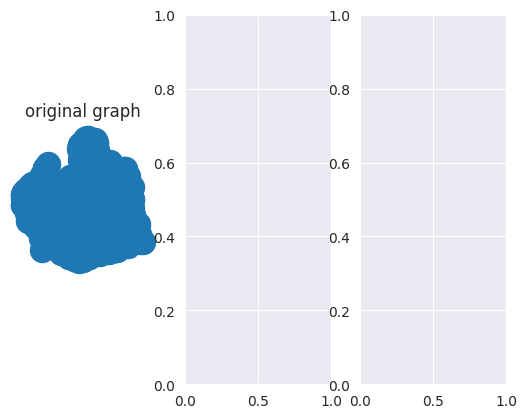

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

fig, ax = plt.subplots(ncols=3)
nx.draw(graph, with_labels=False, cmap=sns.color_palette("Spectral"), ax=ax[0])
ax[0].set_aspect('equal')
ax[0].set_title("original graph")